In [1]:
import time
import itertools
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from package import geometry, triangulation

In [2]:
cube2d = np.array(list(itertools.product([1, -1], repeat=2)))
cube3d = np.array(list(itertools.product([1, -1], repeat=3)))
cube4d = np.array(list(itertools.product([1, -1], repeat=4)))

truncated_octahedron = np.array(list(itertools.permutations([0, 1, 2], 3)))
truncated_octahedron = np.concatenate([truncated_octahedron*np.array(i) for i in itertools.product([1, -1], repeat=3)])
truncated_octahedron = 0.5*np.unique(truncated_octahedron, axis=0)

figures = {'cube2d': cube2d, 
           'cube3d': cube3d, 
           'TrOcth': truncated_octahedron, 
           'cube4d': cube4d, }

for key in figures:
    print(f'{key}: Dimension: {figures[key].shape[1]}; Vertices: {figures[key].shape[0]}')

cube2d: Dimension: 2; Vertices: 4
cube3d: Dimension: 3; Vertices: 8
TrOcth: Dimension: 3; Vertices: 24
cube4d: Dimension: 4; Vertices: 16


# Geometry

In [3]:
matrices = {}
hspaces = {}
for key in figures:
    figure = figures[key]
    clock = time.perf_counter()
    m_list, h_list = geometry.get_hyperspaces_containing(figure)
    clock = time.perf_counter() - clock
    matrices.update({key : m_list.copy()})
    hspaces.update({key : [i for i in h_list]})
    print("Hyperspcaes for {0} has been calculated in {1:.4f} seconds.".format(key, clock))

print()
for key in hspaces:
    lengths = np.array([len(hspace) for hspace in hspaces[key]])
    length2 = []
    for length in np.unique(lengths):
        length2.append(f"Hyperspaces size {length} : {(lengths == length).sum()}")
    msg = f"Figure {key}\nHyperspaces total: {len(lengths)}\n" + '\n'.join(length2) + '\n'
    print(msg)

Hyperspcaes for cube2d has been calculated in 0.0012 seconds.
Hyperspcaes for cube3d has been calculated in 0.0051 seconds.
Hyperspcaes for TrOcth has been calculated in 0.0767 seconds.
Hyperspcaes for cube4d has been calculated in 0.1035 seconds.

Figure cube2d
Hyperspaces total: 2
Hyperspaces size 2 : 2

Figure cube3d
Hyperspaces total: 6
Hyperspaces size 4 : 6

Figure TrOcth
Hyperspaces total: 51
Hyperspaces size 4 : 48
Hyperspaces size 8 : 3

Figure cube4d
Hyperspaces total: 20
Hyperspaces size 6 : 8
Hyperspaces size 8 : 12



In [4]:
halfs = {}
for key in figures:
    figure = np.array(figures[key])
    hspace = hspaces[key]
    lengths = np.array([len(hspc) for hspc in hspace])
    matrix = matrices[key][np.where(lengths == max(lengths))[0][0]]
    clock = time.perf_counter()
    half = geometry.get_half(figure, matrix)
    clock = time.perf_counter() - clock
    halfs.update({key : half})
    print("Half for {0} has been calculated in {1:.4f} seconds.".format(key, clock))
    
print('\nHalfs I got:')
for key in halfs:
    print(f'{key}: Dimension: {halfs[key].shape[1]}; Vertices: {halfs[key].shape[0]}')
    
assert [halfs[key].shape[0] for key in halfs] == [3, 6, 16, 12]

Half for cube2d has been calculated in 0.0003 seconds.
Half for cube3d has been calculated in 0.0003 seconds.
Half for TrOcth has been calculated in 0.0014 seconds.
Half for cube4d has been calculated in 0.0005 seconds.

Halfs I got:
cube2d: Dimension: 2; Vertices: 3
cube3d: Dimension: 3; Vertices: 6
TrOcth: Dimension: 3; Vertices: 16
cube4d: Dimension: 4; Vertices: 12


In [5]:
normals = {}
for key in figures:
    figure = figures[key]
    matrices_key = matrices[key]
    normals_key = []
    clock = time.perf_counter()
    for matrix in matrices_key:
        normals_matrix = geometry.get_normal(matrix)
        normals_key.append(normals_matrix)
    clock = time.perf_counter() - clock
    normals.update({key : np.array(normals_key)})
    print("All normals for hyperspaces in {0} has been calculated in {1:.4f} seconds.".format(key, clock))
    
print()
for key in normals:
    print(f"normals['{key}'].shape = {normals[key].shape}")

All normals for hyperspaces in cube2d has been calculated in 0.0004 seconds.
All normals for hyperspaces in cube3d has been calculated in 0.0011 seconds.
All normals for hyperspaces in TrOcth has been calculated in 0.0027 seconds.
All normals for hyperspaces in cube4d has been calculated in 0.0010 seconds.

normals['cube2d'].shape = (2, 2)
normals['cube3d'].shape = (6, 3)
normals['TrOcth'].shape = (51, 3)
normals['cube4d'].shape = (20, 4)


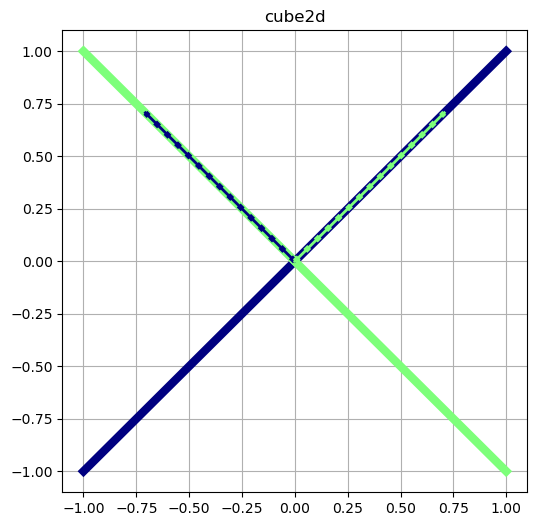

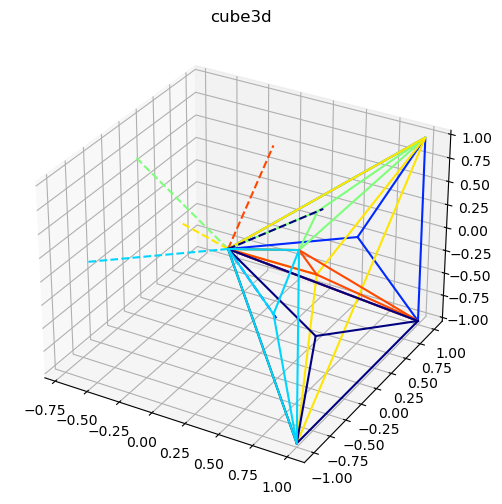

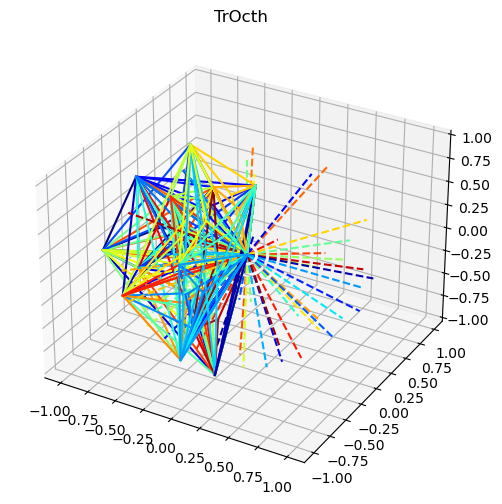

In [6]:
#%matplotlib notebook

cmap = cm.jet

for key in figures:
    figure = figures[key]
    dim = figure.shape[-1]
    normals_key = normals[key]
    colors = [cmap(i/len(normals_key)) for i in range(len(normals_key))]
    np.random.shuffle(colors)
    hyperspaces = hspaces[key]
    if dim == 2:
        plt.figure(figsize=(6, 6))
        plt.title(key)
        for i in range(len(normals_key)):
            hyperspace = hyperspaces[i]
            for hspc in hyperspace:
                p = figure[hspc]
                x = [0, p[0]]
                y = [0, p[1]]
                plt.plot(x, y, linewidth=6, color=colors[i])
        for i in range(len(normals_key)):
            normal = normals_key[i]
            plt.plot([0, normal[0]], [0, normal[1]], color=colors[i], linewidth=4, linestyle=':')
            plt.plot([0, normal[0]], [0, normal[1]], color=colors[i], linewidth=2, linestyle='-')
        plt.grid(True)
        plt.show()
    if dim == 3:
        ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
        ax.set_title(key)
        for i in range(len(normals_key)):
            matrix = matrices[key][i]
            x = np.append(matrix[:, 0], matrix[0, 0])
            y = np.append(matrix[:, 1], matrix[0, 1])
            z = np.append(matrix[:, 2], matrix[0, 2])
            ax.plot3D(x, y, z, color=colors[i])
            center = matrix.mean(axis=0)
            for k in range(3):
                x = [center[0], matrix[k, 0]]
                y = [center[1], matrix[k, 1]]
                z = [center[2], matrix[k, 2]]
                ax.plot3D(x, y, z, color=colors[i])
            normal = normals_key[i]
            x = [0, normal[0]]
            y = [0, normal[1]]
            z = [0, normal[2]]
            ax.plot3D(x, y, z, color=colors[i], linestyle='--')
        plt.show(ax)

In [7]:
refs = {}
for key in figures:
    figure = figures[key]
    hspace = hspaces[key]
    lengths = np.array([len(hspc) for hspc in hspace])
    normal = normals[key][np.where(lengths == max(lengths))[0][0]]
    half = halfs[key]
    
    clock = time.perf_counter()
    ref = geometry.reflect(half, normal)
    clock = time.perf_counter() - clock
    refs.update({key : ref})
    print("Half for {0} has been reflected in {1:.4f} seconds.".format(key, clock))

print('\nReflections of halfs I got:')
for key in halfs:
    print(f'{key}: Dimension: {refs[key].shape[1]}; Vertices: {refs[key].shape[0]}')
    
assert [refs[key].shape[0] for key in refs] == [halfs[key].shape[0] for key in halfs]

Half for cube2d has been reflected in 0.0001 seconds.
Half for cube3d has been reflected in 0.0001 seconds.
Half for TrOcth has been reflected in 0.0000 seconds.
Half for cube4d has been reflected in 0.0000 seconds.

Reflections of halfs I got:
cube2d: Dimension: 2; Vertices: 3
cube3d: Dimension: 3; Vertices: 6
TrOcth: Dimension: 3; Vertices: 16
cube4d: Dimension: 4; Vertices: 12


In [8]:
for key in refs:
    print(f"Figure: {key}")
    half_key = halfs[key].astype(float)
    refs_key = refs[key]
    n = str(half_key).find('\n') + 2
    sf = "{0:" + str(n) + "s}{1:"+str(n) + "s}"
    print(sf.format('Half', 'Reflection'))
    for i in range(len(half_key)):
        print(sf.format(str(half_key).split('\n')[i], 
              str(refs_key).split('\n')[i]))
    print()

Figure: cube2d
Half        Reflection  
[[ 1.  1.]  [[ 1.  1.]  
 [ 1. -1.]   [-1.  1.]  
 [-1. -1.]]  [-1. -1.]] 

Figure: cube3d
Half            Reflection      
[[ 1.  1.  1.]  [[ 1.  1.  1.]  
 [ 1.  1. -1.]   [ 1.  1. -1.]  
 [-1.  1.  1.]   [ 1. -1.  1.]  
 [-1.  1. -1.]   [ 1. -1. -1.]  
 [-1. -1.  1.]   [-1. -1.  1.]  
 [-1. -1. -1.]]  [-1. -1. -1.]] 

Figure: TrOcth
Half               Reflection         
[[-1.  -0.5  0. ]  [[-1.  -0.5  0. ]  
 [-1.   0.  -0.5]   [-1.   0.   0.5]  
 [-1.   0.5  0. ]   [-1.   0.5  0. ]  
 [-0.5 -1.   0. ]   [-0.5 -1.   0. ]  
 [-0.5  0.  -1. ]   [-0.5  0.   1. ]  
 [-0.5  1.   0. ]   [-0.5  1.   0. ]  
 [ 0.  -1.  -0.5]   [ 0.  -1.   0.5]  
 [ 0.  -0.5 -1. ]   [ 0.  -0.5  1. ]  
 [ 0.   0.5 -1. ]   [ 0.   0.5  1. ]  
 [ 0.   1.  -0.5]   [ 0.   1.   0.5]  
 [ 0.5 -1.   0. ]   [ 0.5 -1.   0. ]  
 [ 0.5  0.  -1. ]   [ 0.5  0.   1. ]  
 [ 0.5  1.   0. ]   [ 0.5  1.   0. ]  
 [ 1.  -0.5  0. ]   [ 1.  -0.5  0. ]  
 [ 1.   0.  -0.5]   [ 1.   0.   0.5] 

In [9]:
half_unions = {}
for key in figures:
    half_unions.update({key : np.unique(np.concatenate([halfs[key], refs[key]]), axis=0)})
    
print('Unions of halfs')
for key in half_unions:
    print(f'{key}: Dimension: {half_unions[key].shape[1]}; Vertices: {half_unions[key].shape[0]}')
    
for key in figures:
    try:
        assert (np.sort(figures[key], axis=0) == np.sort(half_unions[key], axis=0)).all()
    except AssertionError:
        print()
        print(f"Something is wrong for figure {key}:")
        print(f"figures['{key}']:\n{figures[key]}")
        print(f"half_unions['{key}']:\n{half_unions[key]}")

Unions of halfs
cube2d: Dimension: 2; Vertices: 4
cube3d: Dimension: 3; Vertices: 8
TrOcth: Dimension: 3; Vertices: 24
cube4d: Dimension: 4; Vertices: 16


# Triangulation

In [10]:
triangulations_simple = {}
for key in figures:
    figure = figures[key]
    clock = time.perf_counter()
    tri = triangulation.triangulate_body(figure)
    clock = time.perf_counter() - clock
    triangulations_simple.update({key : tri.copy()})
    print("Triangulation for {0} has been calculated in {1:.4f} seconds.".format(key, clock))
    
print()
for key in normals:
    print(f"triangulations_simple[{key.__repr__()}].shape = {triangulations_simple[key].shape}")

Triangulation for cube2d has been calculated in 0.0004 seconds.
Triangulation for cube3d has been calculated in 0.0003 seconds.
Triangulation for TrOcth has been calculated in 0.0005 seconds.
Triangulation for cube4d has been calculated in 0.0004 seconds.

triangulations_simple['cube2d'].shape = (2, 3, 2)
triangulations_simple['cube3d'].shape = (6, 4, 3)
triangulations_simple['TrOcth'].shape = (34, 4, 3)
triangulations_simple['cube4d'].shape = (22, 5, 4)


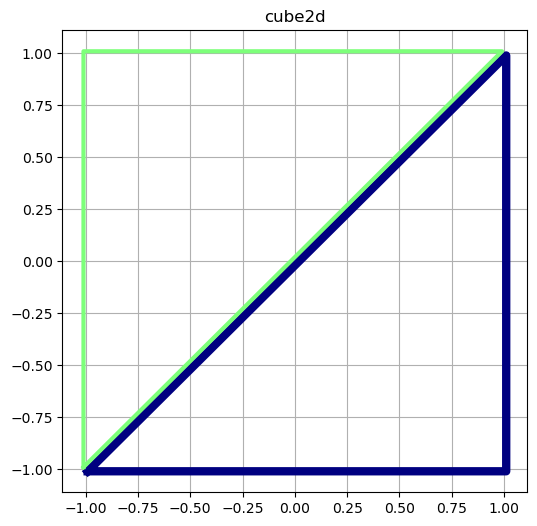

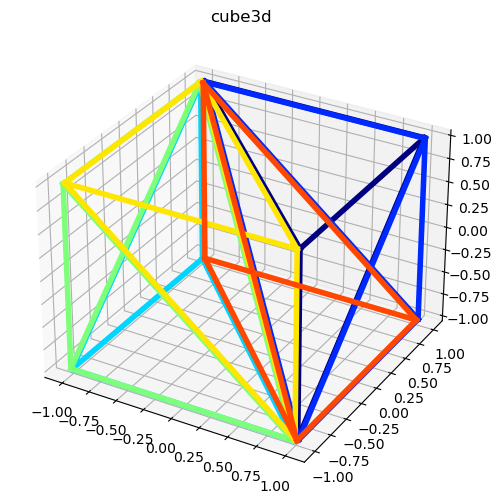

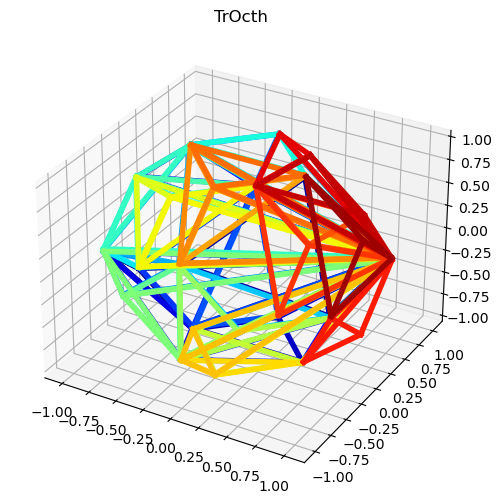

In [11]:
cmap = cm.jet
eps = 0.03

for key in triangulations_simple:
    tri = triangulations_simple[key]
    dim = tri.shape[-1]
    
    centers = np.array([simplex.mean(axis=0) for simplex in tri])
    moves = eps*centers
    colors = [cmap(i/len(tri)) for i in range(len(tri))]
    
    if dim == 2:
        plt.figure(figsize=(6, 6))
        plt.title(key)
        for i in range(len(tri)):
            simplex = tri[i] + moves[i]
            color = colors[i]
            x = np.append(simplex[:, 0], simplex[0, 0])
            y = np.append(simplex[:, 1], simplex[0, 1])
            plt.plot(x, y, color=color, linewidth=3*(2-i))
        plt.grid(True)
        plt.show()
    if dim == 3:
        ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
        ax.set_title(key)
        for i in range(len(tri)):
            simplex = tri[i] + moves[i]
            color = colors[i]
            for edge in itertools.combinations(simplex, 2):
                xyz = np.array(edge)
                ax.plot3D(xyz[:, 0], xyz[:, 1], xyz[:, 2], color=color, linewidth=4)
        plt.show(ax)

In [12]:
triangulations_ref = {}
for key in figures:
    figure = figures[key]
    clock = time.perf_counter()
    tri = triangulation.triangulate_body_reflecting_half(figure)
    clock = time.perf_counter() - clock
    triangulations_ref.update({key : tri.copy()})
    print("Triangulation for {0} has been calculated in {1:.4f} seconds.".format(key, clock))
    
print()
for key in normals:
    print(f"triangulations_ref[{key.__repr__()}].shape = {triangulations_ref[key].shape}")

Triangulation for cube2d has been calculated in 0.0031 seconds.
Triangulation for cube3d has been calculated in 0.0069 seconds.
Triangulation for TrOcth has been calculated in 0.0737 seconds.
Triangulation for cube4d has been calculated in 0.0973 seconds.

triangulations_ref['cube2d'].shape = (2, 3, 2)
triangulations_ref['cube3d'].shape = (6, 4, 3)
triangulations_ref['TrOcth'].shape = (38, 4, 3)
triangulations_ref['cube4d'].shape = (22, 5, 4)


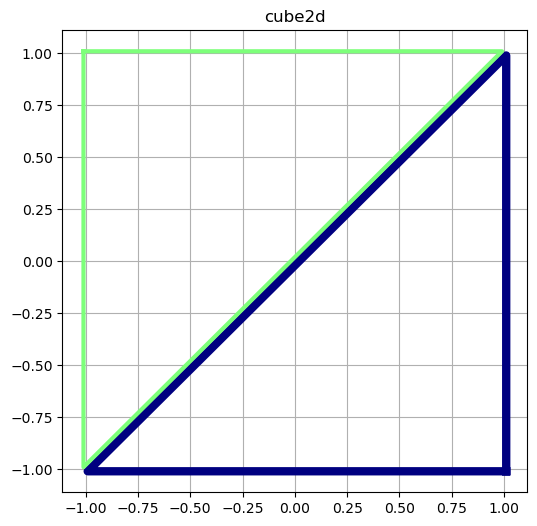

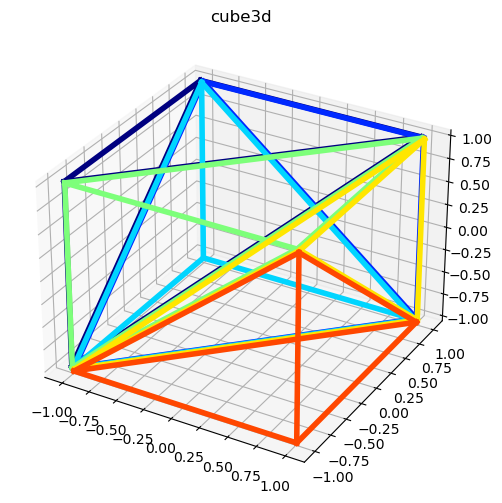

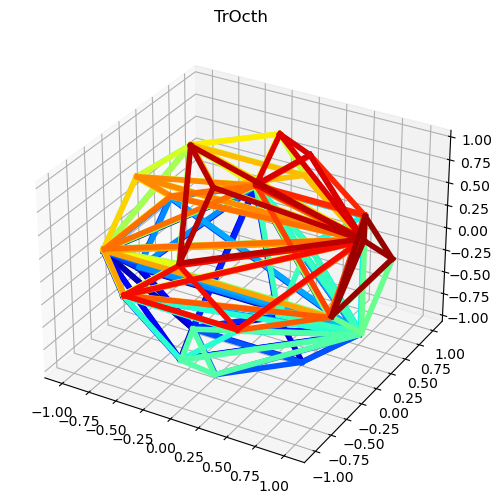

In [13]:
cmap = cm.jet
eps = 0.03

for key in triangulations_ref:
    tri = triangulations_ref[key]
    dim = tri.shape[-1]
    
    centers = np.array([simplex.mean(axis=0) for simplex in tri])
    moves = eps*centers
    colors = [cmap(i/len(tri)) for i in range(len(tri))]
    
    if dim == 2:
        plt.figure(figsize=(6, 6))
        plt.title(key)
        for i in range(len(tri)):
            simplex = tri[i] + moves[i]
            color = colors[i]
            x = np.append(simplex[:, 0], simplex[0, 0])
            y = np.append(simplex[:, 1], simplex[0, 1])
            plt.plot(x, y, color=color, linewidth=3*(2-i))
        plt.grid(True)
        plt.show()
    if dim == 3:
        ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
        ax.set_title(key)
        for i in range(len(tri)):
            simplex = tri[i] + moves[i]
            color = colors[i]
            for edge in itertools.combinations(simplex, 2):
                xyz = np.array(edge)
                ax.plot3D(xyz[:, 0], xyz[:, 1], xyz[:, 2], color=color, linewidth=4)
        plt.show(ax)

Как мы видим на примере куба трёхмерного, у двух пар противоположных сторон не совпадает проекция при использовании отражений. Грустно.

Нужно будет функции проверки о противоположных гранях написать. Можно для триангуляции $T$ реализовать так:

1. Найти все нормали $n_i$ внешних плоскостей
2. Проверить, $S_{n_i}T = T$?

или

1. Найти все пары $\alpha_i, \beta_i$ противоположных внешних плоскостей
2. Посчитать нормали $n_i$ для этих плоскостей
3. Найти симплициальные разбиентя $T(\alpha_i), T(\beta_i)$ для всех пар плоскостей $\alpha_i, \beta_i$ - т.е. все симплексы $T$, лежащие в $\alpha_i$ и $\beta_i$
4. Проверить, $S_{ni}(T(\alpha_i) \cup T(\beta_i)) = T(\alpha_i) \cup T(\beta_i)$

В обоих случаях нужно реализвать метод сравнения разбиений на симплексы одного и того же облака точек.

Для двух симплицальных разбиений одного и того же облака $T_1$ и $T_2$ можно попробовать так:
1. Привести его к типу `float`
2. Отсортировать каждый симплекс и привести к типу `string`
3. Отсартировать массивы строк и сравнить их